## Questions
The data was completely collected on 2020-08-05

What are the questions that I want to answer, given the data that I now have?
- How many jobs are remote?
- For jobs with pay range information, what is the average floor for each job category? Ceiling?
- Is there a tendency for a particular job to be remote more than another?
- What are the top 20 jobs that are being sought after?
- When you remove very old posts (30+ days) how much do these figures change?
    - what could be the reason for some of the older jobs hanging out on the job boards?
- What are the top 20 companies really pushing to hire?
- What are the top 20 locations that are hiring? Does it matter?

This could be structured in the typical "who, what, where, when"
- **Who** -> who are the companies that are recruiting the most?
- **What** -> what are the jobs that are most sought after
- **Where** -> what states are hiring the most people (with the understanding that a lot of work is remote, but this could change if restrictions begin to lift)
- **When** -> are there less newer jobs (7 days or newer). Does it matter?

### Extra 
- how many details are included in the job description snippet?
- can we use LDA to extract the most commonly desired topics?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

In [2]:
jobs = pd.read_csv('jobs_cleaned.csv', sep='|')
jobs.head()

,role,company,location,pay,remote,details,job_post_age,search_field,role_formatted,distances,job_label,role_plus_details,predicted_role
0,Lead Software Engineer - eCommerce,COVETRUS INC,"Birmingham, AL 35203",NaN,0,"Our advanced web tools, client marketing progr...",30+ days ago,Marketing Technologist,lead software engineer ecommerce,0.000000,Lead Software Engineer - eCommerce,lead software engineer ecommerce our advanced...,Software Developer
1,Snr Key Account Technology Engineer II - ALD,ASM,"Phoenix, AZ",NaN,0,Related work experience can include process en...,30+ days ago,Marketing Technologist,snr key account technology engineer ii ald,0.273471,Snr Key Account Technology Engineer II - ALD,snr key account technology engineer ii ald re...,Systems Engineer
2,Salesforce Developer - US Delivery Center,Deloitte,"Gilbert, AZ 85297",NaN,0,Build Salesforce solutions on Salesforce Cloud...,28 days ago,Marketing Technologist,salesforce developer us delivery center,0.000000,Salesforce Developer - US Delivery Center,salesforce developer us delivery center build...,Cloud Architect
3,Lead Software Engineer - eCommerce,COVETRUS INC,"Phoenix, AZ 85085 (North Gateway area)",NaN,0,"Our advanced web tools, client marketing progr...",30+ days ago,Marketing Technologist,lead software engineer ecommerce,0.000000,Lead Software Engineer - eCommerce,lead software engineer ecommerce our advanced...,Software Developer
4,UI/UX Designer-Clearance Required,Deloitte,"Gilbert, AZ 85297",NaN,0,We implement and operate the technology platfo...,18 days ago,Marketing Technologist,ui ux designer clearance required,0.000000,UI/UX Designer-Clearance Required,ui ux designer clearance required we implement...,UX Designer


In [3]:
jobs.shape

(117809, 13)

In [4]:
# There's a good chance there will be duplicates
jobs = jobs.drop_duplicates(subset=('role', 'company', 'location'))
print(jobs.shape)

(76373, 13)


### Clean Data

Because I would like to use the job post age to understand the jobs in the context of removal of older jobs postings, I need to turn the column to integers.

In [5]:
jobs.loc[(jobs['job_post_age'] == 'Just posted') |
         (jobs['job_post_age'] == 'Today'), 'job_post_age'] = '0'
jobs['job_post_age'].value_counts()

30+ days ago    40715
0                2799
1 day ago        2731
6 days ago       2199
5 days ago       2192
7 days ago       2084
8 days ago       1808
2 days ago       1729
13 days ago      1551
12 days ago      1504
14 days ago      1423
15 days ago      1373
9 days ago       1204
21 days ago      1164
20 days ago      1162
19 days ago      1092
22 days ago      1089
28 days ago      1032
27 days ago      1006
26 days ago       993
16 days ago       928
29 days ago       928
4 days ago        924
23 days ago       889
11 days ago       569
18 days ago       451
25 days ago       310
3 days ago        204
10 days ago       124
17 days ago       102
24 days ago        94
Name: job_post_age, dtype: int64

In [6]:
jobs['job_post_age'] = jobs['job_post_age'].str.replace('[^0-9]', '')
jobs['job_post_age'] = jobs['job_post_age'].astype(int)
jobs.dtypes

role                  object
company               object
location              object
pay                   object
remote                 int64
details               object
job_post_age           int64
search_field          object
role_formatted        object
distances            float64
job_label             object
role_plus_details     object
predicted_role        object
dtype: object

Before removing old jobs, what does the distribution of remote and non remote jobs look like? A '1' indicates a remote opportunity. *NOTE*: The absence of a 'Remote' tag on a job does not necessarily mean that a job is *not* remote, especially in the context of the COVID-19 outbreak, where many companies temporarily moved to a remote work situation.

In [7]:
jobs['remote'] = jobs['remote'].astype(int)

0    0.874013
1    0.125987
Name: remote, dtype: float64


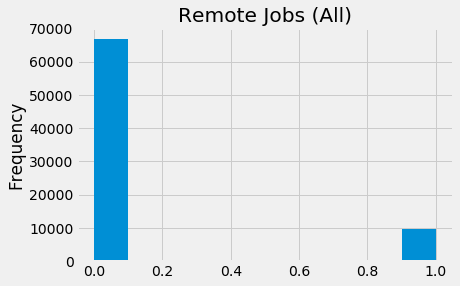

In [8]:
# the goal here is to see if there is any major difference
# in the 'Remote' status of a job when job_post_age changes
print(jobs['remote'].value_counts(normalize=True))
jobs['remote'].plot.hist(title="Remote Jobs (All)");

0    0.824612
1    0.175388
Name: remote, dtype: float64


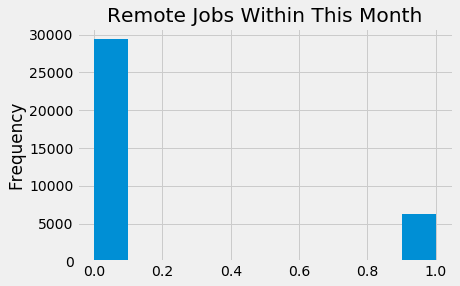

In [9]:
recent_jobs = jobs[jobs['job_post_age'] < 30]
print(recent_jobs['remote'].value_counts(normalize=True))
recent_jobs['remote'].plot.hist(title="Remote Jobs Within This Month");

What about jobs within a week of collection?

0    0.811667
1    0.188333
Name: remote, dtype: float64


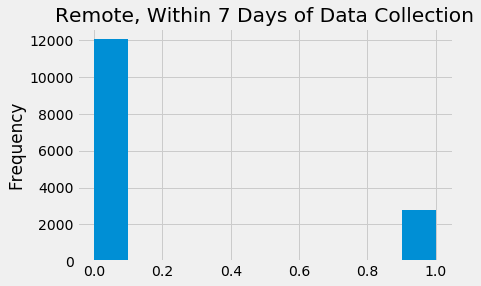

In [10]:
recent_week = jobs[jobs['job_post_age'] <= 7]
print(recent_week['remote'].value_counts(normalize=True))
recent_week['remote'].plot.hist(title="Remote, Within 7 Days of Data Collection");

There does appear to be a noticeable change in the proportion of jobs that choose to display the 'Remote' flag. As the posts get newer, the proportion shifts slightly in favor of remote jobs. Although this is obvious, it's an interesting dynamic to document.

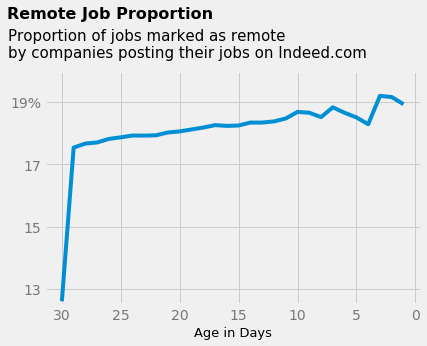

In [11]:
# plot the change in proportion of remote jobs
remote_jobs_proportion = [
    jobs[jobs['job_post_age'] <= i]['remote']
    .value_counts(normalize=True)[1]
    for i in range(30, 0, -1)
]

plt.plot(remote_jobs_proportion)
plt.xticks(range(0, 31, 5), 
           labels=['30','25','20','15','10','5','0'],
           alpha=0.5)

plt.grid(True)
# plt.ylabel("Proportion", fontsize=13)
plt.yticks([.13, .15, .17, .19],
           labels=['13', '15', '17', '19%'],
           alpha=0.5)

plt.ylim(0.125, 0.20)
plt.title("Remote Job Proportion", x=-0.1, y=1.2,
          fontweight='bold',horizontalalignment='left',
          fontsize=16)
plt.suptitle("Proportion of jobs marked as remote\n"
             "by companies posting their jobs on Indeed.com",
             x=-0.005, y=1.03, horizontalalignment='left',
             fontsize=15)
plt.xlabel("Age in Days", fontsize=13)
plt.show()

### Pay Range Columns
It would be ideal to create pay range columns for the individual pay ranges ('an hour', 'a month', 'a year'. excluding the smallest groups) in order to create two standardized yearly pay columns like so:

|pay_floor|pay_ceiling|
|---------|-----------|
|50000    |90000      |
|75000    |125345     |

In [12]:
jobs['pay'] = jobs['pay'].fillna('N/A')
jobs.head()

,role,company,location,pay,remote,details,job_post_age,search_field,role_formatted,distances,job_label,role_plus_details,predicted_role
0,Lead Software Engineer - eCommerce,COVETRUS INC,"Birmingham, AL 35203",N/A,0,"Our advanced web tools, client marketing progr...",30,Marketing Technologist,lead software engineer ecommerce,0.000000,Lead Software Engineer - eCommerce,lead software engineer ecommerce our advanced...,Software Developer
1,Snr Key Account Technology Engineer II - ALD,ASM,"Phoenix, AZ",N/A,0,Related work experience can include process en...,30,Marketing Technologist,snr key account technology engineer ii ald,0.273471,Snr Key Account Technology Engineer II - ALD,snr key account technology engineer ii ald re...,Systems Engineer
2,Salesforce Developer - US Delivery Center,Deloitte,"Gilbert, AZ 85297",N/A,0,Build Salesforce solutions on Salesforce Cloud...,28,Marketing Technologist,salesforce developer us delivery center,0.000000,Salesforce Developer - US Delivery Center,salesforce developer us delivery center build...,Cloud Architect
3,Lead Software Engineer - eCommerce,COVETRUS INC,"Phoenix, AZ 85085 (North Gateway area)",N/A,0,"Our advanced web tools, client marketing progr...",30,Marketing Technologist,lead software engineer ecommerce,0.000000,Lead Software Engineer - eCommerce,lead software engineer ecommerce our advanced...,Software Developer
4,UI/UX Designer-Clearance Required,Deloitte,"Gilbert, AZ 85297",N/A,0,We implement and operate the technology platfo...,18,Marketing Technologist,ui ux designer clearance required,0.000000,UI/UX Designer-Clearance Required,ui ux designer clearance required we implement...,UX Designer


In [13]:
jobs['pay'] = jobs['pay'].str.replace('$', '')
jobs['pay'] = jobs['pay'].str.replace(',', '')

In order to convert the ranges to floor and ceiling, i need to find out how many different categories of pay range there is (i.e. "a year", "a week", "an hour", etc...)

In [14]:
jobs[jobs['pay'].str.contains('\d+\s\-\s\d+\s(a|an)\s+.*')]['pay'].str.replace('[^a-zA-z]', '').value_counts()

/home/jose/miniconda3/envs/unit2/lib/python3.7/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


ayear     4733
anhour    2062
amonth     162
aweek       17
aday        10
Name: pay, dtype: int64

For practicality's sake, I'll only convert ranges with "a year", "a month", or "an hour".

In [15]:
jobs['yearly'] = jobs['pay']

# convert anything in the yearly column that isnt yearly to 'N/A'
jobs.loc[~jobs['yearly'].str.contains('a year'), 'yearly'] = 'N/A' 

# remove 'a year' from yearly column
jobs['yearly'] = jobs['yearly'].str.replace('[^0-9\-]', '')

# create floor pay column
jobs['floor_pay_yearly'] = jobs['yearly'].str.replace('\-\d+', '')
jobs.loc[jobs['floor_pay_yearly'] == '', 'floor_pay_yearly'] = np.nan
jobs['floor_pay_yearly'] = jobs['floor_pay_yearly'].astype(float)

# create ceiling pay column
jobs['ceiling_pay_yearly'] = jobs['yearly'].str.replace('\d+\-', '')
jobs.loc[jobs['ceiling_pay_yearly'] == '', 'ceiling_pay_yearly'] = np.nan
jobs['ceiling_pay_yearly'] = jobs['ceiling_pay_yearly'].astype(float)

In [16]:
# repeat the process with monthly pay ranges
jobs['monthly'] = jobs['pay']

# anything in the new column that isn't part of the category becomes 'N/A'
jobs.loc[~jobs['monthly'].str.contains('a month'), 'monthly'] = 'N/A'

# remove 'a month' from column
jobs['monthly'] = jobs['monthly'].str.replace('[^0-9\-]', '')
jobs.loc[jobs['monthly'] == '', 'monthly'] = np.nan

# insert floor and ceiling into the corresponding yearly column
jobs.loc[jobs['monthly'].notnull(), 'floor_pay_yearly'] = (jobs['monthly']
                                                       .str.replace('\-\d+', '')
                                                       .astype(float) * 12)
jobs.loc[jobs['monthly'].notnull(), 'ceiling_pay_yearly'] = (jobs['monthly']
                                                            .str.replace('\d+\-', '')
                                                            .astype(float) * 12)

Here, I'm multiplying hourly rates by 2 and then by 1000. This is operating under the rough assumption that if a person makes 70,000 dollars a year, they are working 40 hours a week for ~52 weeks out of the year:

$(\$35\ per\ hour) \times (40\ hours\ per\ week) \times (52\ weeks) \approx \$70,000\ a\ year$

In [17]:
# repeat the process with hourly pay ranges
jobs['hourly'] = jobs['pay']

# anything in the new column that isn't part of the category becomes 'N/A'
jobs.loc[~jobs['hourly'].str.contains('an hour'), 'hourly'] = 'N/A'

# remove 'an hour' from new column
jobs['hourly'] = jobs['hourly'].str.replace('[^0-9\-\.]', '')
jobs.loc[jobs['hourly'] == '', 'hourly'] = np.nan

# insert floor and ceiling into the corresponding yearly column
jobs.loc[jobs['hourly'].notnull(), 'floor_pay_yearly'] = ((jobs['hourly']
                                                       .str.replace('\-\d+\.*\d*', '')
                                                       .astype(float) * 2) * 1000)
jobs.loc[jobs['hourly'].notnull(), 'ceiling_pay_yearly'] = ((jobs['hourly']
                                                            .str.replace('\d+\.*\d*\-', '')
                                                            .astype(float) * 2) * 1000)

In [18]:
print(f"Average Pay Floor: ${round(jobs['floor_pay_yearly'].mean(), 2)}")
print(f"Average Pay Ceiling: ${round(jobs['ceiling_pay_yearly'].mean(), 2)}")

Average Pay Floor: $75129.11
Average Pay Ceiling: $95086.54


Before moving on, I'd like to make sure there aren't any obvious outliers/potential mistakes

In [19]:
jobs['floor_pay_yearly'].describe()

count      8796.000000
mean      75129.109936
std       34013.281179
min        9600.000000
25%       50000.000000
50%       70000.000000
75%       98000.000000
max      300000.000000
Name: floor_pay_yearly, dtype: float64

A max yearly pay of 300k sounds like a mistake or influence from outliers, and so does a minimum of 9600 a year. I'll consider anything over 200k or under 30k suspect.

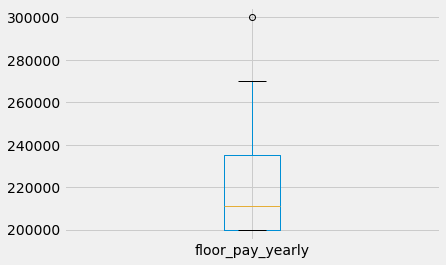

In [20]:
jobs[['floor_pay_yearly']][jobs['floor_pay_yearly'] >= 200000].plot.box();

In [21]:
jobs[['role', 'pay', 'details', 'floor_pay_yearly']][jobs['floor_pay_yearly'] >= 200000].shape

(46, 4)

In [22]:
jobs[jobs['floor_pay_yearly'] >= 300000]

,role,company,location,pay,remote,details,job_post_age,search_field,role_formatted,distances,job_label,role_plus_details,predicted_role,yearly,floor_pay_yearly,ceiling_pay_yearly,monthly,hourly
100301,Project Manager - Potable - Private,HR Green,"Saint Paul, MN 55114 (St. Anthony area)",300000 a year,0,Assists with pre-positioning strategies; ident...,30,Technical Lead,project manager potable private,0.0,Project Manager - Potable - Private,project manager potable private assists with...,Product Manager,300000,300000.0,300000.0,NaN,NaN


The jobs with \$300000 per year pay ceilings will be removed, as they are pretty extreme outliers

In [23]:
jobs = jobs.drop([100301])

In [24]:
jobs['floor_pay_yearly'].describe()

count      8795.000000
mean      75103.541899
std       33930.576735
min        9600.000000
25%       50000.000000
50%       70000.000000
75%       97987.500000
max      270000.000000
Name: floor_pay_yearly, dtype: float64

The lower range of pay is a minimum of 9600 a year, this still seems strange. Jobs with a salary less than 20000 will be dropped

In [25]:
jobs = jobs.drop(jobs[jobs['floor_pay_yearly'] < 20000].index)

75422.12654320987


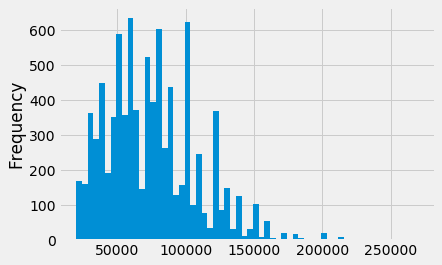

In [26]:
print(jobs['floor_pay_yearly'].mean())
jobs['floor_pay_yearly'].plot.hist(bins=60);

95446.8565386374


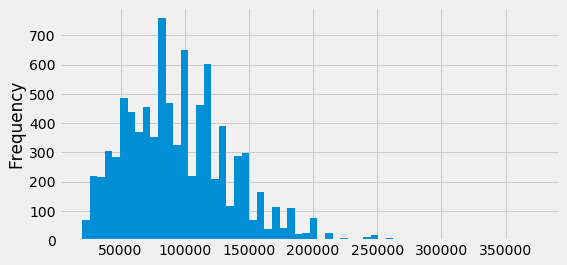

In [27]:
print(jobs['ceiling_pay_yearly'].mean())
jobs['ceiling_pay_yearly'].plot.hist(bins=60, figsize=(8, 4));

Since the distributions are right skewed with a somewhat large scale, log transformation can be used to get a more accurate representation of the mean pay floor and ceiling

/home/jose/miniconda3/envs/unit2/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jose/miniconda3/envs/unit2/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


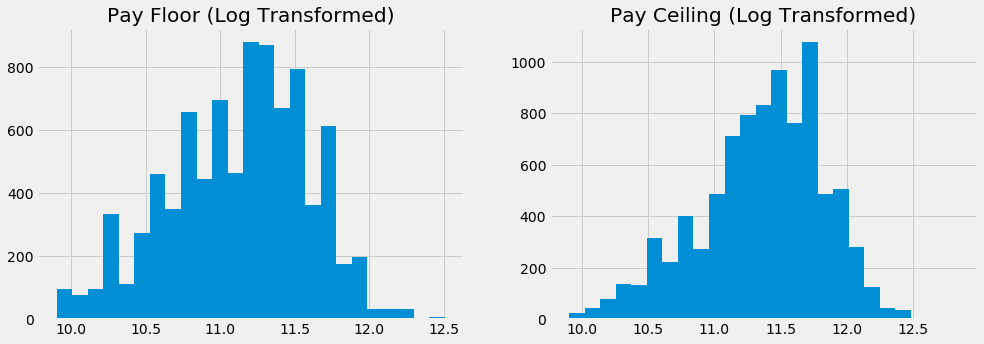

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
n_bins = 25
floor = np.log1p(jobs['floor_pay_yearly'])
ceiling = np.log1p(jobs['ceiling_pay_yearly'])
axes[0].hist(floor, bins=n_bins)
axes[1].hist(ceiling, bins=n_bins)
axes[0].set_title('Pay Floor (Log Transformed)')
axes[1].set_title('Pay Ceiling (Log Transformed)')

for ax in axes:
    ax.grid(True)

plt.show()

In [29]:
print(f"Average Pay Floor (Log Transformed): ${np.expm1(floor.mean())}")
print(f"Average Pay Ceiling (Log Transformed): ${np.expm1(ceiling.mean())}")

Average Pay Floor (Log Transformed): $68099.15565609495
Average Pay Ceiling (Log Transformed): $86262.74328753405


Out of the top ten most posted roles, it may be helpful to know the amount of remote jobs per role

In [30]:
top_ten_roles = jobs['predicted_role'].value_counts()[:10].index
jobs['predicted_role'].value_counts()[:10]

Software Developer           23253
Systems Engineer             10505
Product Manager               8364
Data Analyst                  5513
Systems Administrator         5390
Business Systems Analyst      3850
Data Scientist                3287
Technical Account Manager     2799
Digital Marketing Manager     2766
UX Designer                   2082
Name: predicted_role, dtype: int64

In [31]:
jobs[(jobs['predicted_role'] == 'UX Designer') &
     (jobs['remote'] == 1)]['remote'].value_counts().sum()

325

In [32]:
remote_jobs = {"role":[],
                   "remote": [],
                   "on_site": []}

for r in top_ten_roles:
    remote_jobs["role"].append(r)
    remote_jobs["remote"].append(
        jobs[
          (jobs['predicted_role'] == r) &
          (jobs['remote'] == 1)
        ]['remote'].value_counts().sum()
    )
    remote_jobs["on_site"].append(
        jobs[
          (jobs['predicted_role'] == r) &
          (jobs['remote'] == 0)
        ]['remote'].value_counts().sum()
    )
    
remote_jobs = pd.DataFrame(remote_jobs)

In [33]:
remote_jobs.head()

,role,remote,on_site
0,Software Developer,3375,19878
1,Systems Engineer,906,9599
2,Product Manager,964,7400
3,Data Analyst,509,5004
4,Systems Administrator,410,4980


In [34]:
remote_jobs['percent_remote'] = remote_jobs['remote'] / (remote_jobs['on_site'] +
                                                         remote_jobs['remote'])
remote_jobs['remote_per_1k'] = remote_jobs['remote'] / ((remote_jobs['on_site'] +
                                                         remote_jobs['remote']) /
                                                         1000)

In [35]:
remote_jobs = remote_jobs.sort_values(by='remote_per_1k')

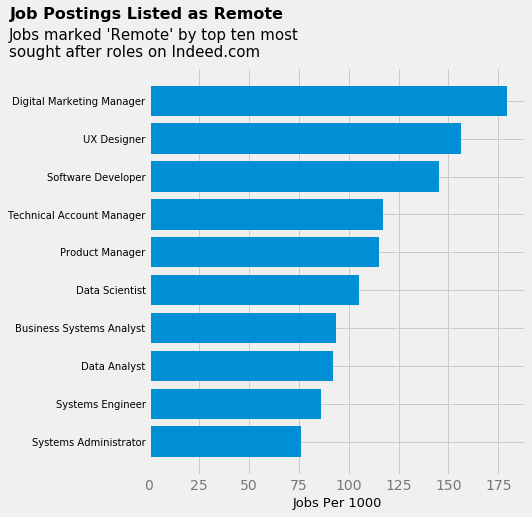

In [96]:
x = np.arange(remote_jobs.shape[0]) 
plt.figure(figsize=(6, 7))
plt.barh(x, remote_jobs['remote_per_1k'])


plt.title("Job Postings Listed as Remote", x=-0.37, y=1.103,
          fontweight='bold',horizontalalignment='left',
          fontsize=16)
plt.suptitle("Jobs marked 'Remote' by top ten most\n"
             "sought after roles on Indeed.com",
             x=-0.245, y=.958, horizontalalignment='left',
             fontsize=15)
plt.yticks(range(10), labels=remote_jobs['role'], 
           fontsize=10)
plt.xticks(alpha=0.5)
plt.xlabel("Jobs Per 1000", fontsize=13)
plt.show()

Here, I'd like to answer the question of average pay floor and ceiling per top 10 most posted roles

In [83]:
# create table of average pay range by top ten job roles
roles = jobs['predicted_role'].value_counts()[:10].index
pay_columns = ['predicted_role', 'floor_pay_yearly', 'ceiling_pay_yearly']
top_ten_only = jobs[jobs['predicted_role'].isin(roles)]
pay_averages = top_ten_only[pay_columns].groupby(['predicted_role']).mean()
pay_averages = pay_averages.sort_values(by='floor_pay_yearly')

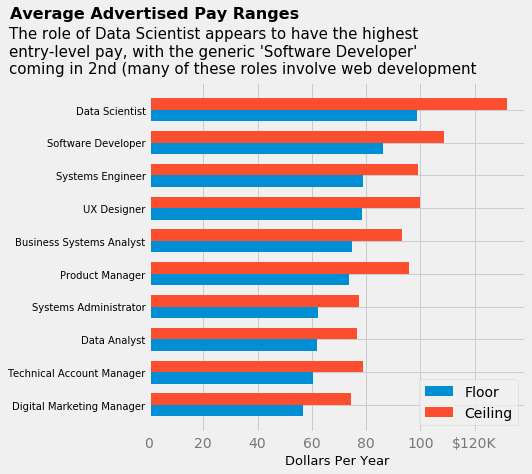

In [234]:
x = np.arange(len(pay_averages))
w = 0.35
plt.figure(figsize=(6, 6))
plt.barh(x - w/2, pay_averages['floor_pay_yearly'], w, label="Floor")
plt.barh(x + w/2, pay_averages['ceiling_pay_yearly'], w, label="Ceiling")

plt.xticks(range(0, 130000, 20000), 
           labels=["0", "20", "40", "60",
                   "80", "100", "$120K"],
           alpha=0.5)

plt.yticks(range(10), labels=pay_averages.index, 
           fontsize=10)
plt.xlabel("Dollars Per Year", fontsize=13)
plt.title("Average Advertised Pay Ranges", x=-0.37, y=1.166,
          fontweight='bold',horizontalalignment='left',
          fontsize=16)
plt.suptitle("The role of Data Scientist appears to have the highest\n"
             "entry-level pay, with the generic 'Software Developer'\n"
             "coming in 2nd (many of these roles involve web development",
             x=-0.245, y=1.01, horizontalalignment='left',
             fontsize=15)
plt.legend()

plt.show()

In [127]:
jobs['company'].value_counts()[:20]

Amazon.com Services LLC                    872
Amazon Web Services, Inc.                  494
Northrop Grumman                           387
Deloitte                                   387
General Dynamics Information Technology    313
Booz Allen Hamilton                        312
LOCKHEED MARTIN CORPORATION                283
CACI                                       279
Leidos                                     274
SAIC                                       232
JPMorgan Chase Bank, N.A.                  229
Apple                                      213
iknowvate technologies                     187
Pearson                                    183
Perspecta                                  177
ManTech International Corporation          176
Facebook                                   174
Microsoft                                  150
PayPal                                     147
BAE Systems                                140
Name: company, dtype: int64

In [129]:
# change Amazon variants to just Amazon
jobs.loc[jobs['company'].str.contains("Amazon")] = "Amazon"

In [344]:
# top 20 hiring companies as of data collection
hiring_comps = {"company": jobs['company'].value_counts()[:20].index,
                "listings": jobs['company'].value_counts()[:20].values}
hc = pd.DataFrame(data=hiring_comps)

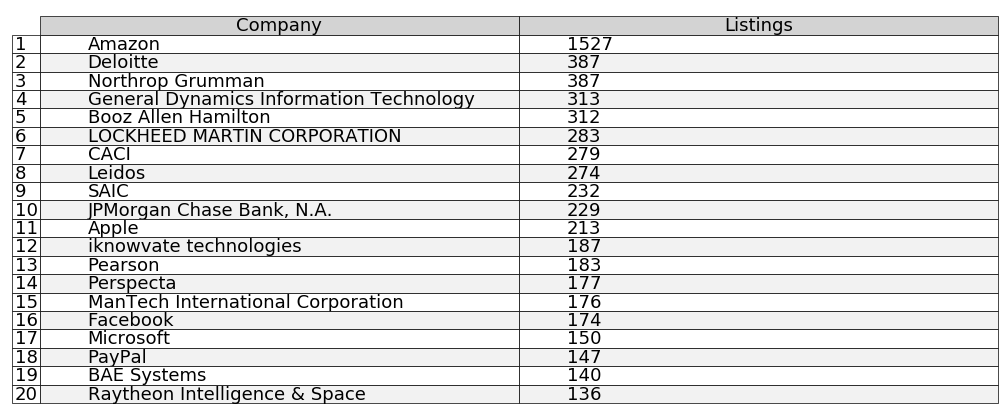

In [345]:
# generally not a great way to make a nice looking table
# will likely end up just writing these in blog
ROWS = hc.shape[0]
COLS = hc.shape[1]
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
ax.table(cellText=[[c,l] for c, l in zip(hc['company'], hc['listings'])],
         colLabels=["Company", "Listings"],
         rowLabels=range(1, ROWS+1),
         cellLoc="left",
         loc="upper left",
         rowColours=["white"]*ROWS,
         colColours=["lightgrey"]*COLS,
         cellColours=[["white" for i in range(COLS)] if j%2==0 else 
                      [".95" for i in range(COLS)] for j in range(ROWS)])
ax.set_facecolor((0,0,0,0))
ax.set_axis_off()
fig.tight_layout()
fig.set_facecolor((0,0,0,0))
plt.grid(False)
plt.show()

In [349]:
# the top 20 hiring locations as of data collection
top_locs = {"location": jobs['location'].value_counts()[:20].index,
                "listings": jobs['location'].value_counts()[:20].values}
tl = pd.DataFrame(data=top_locs)

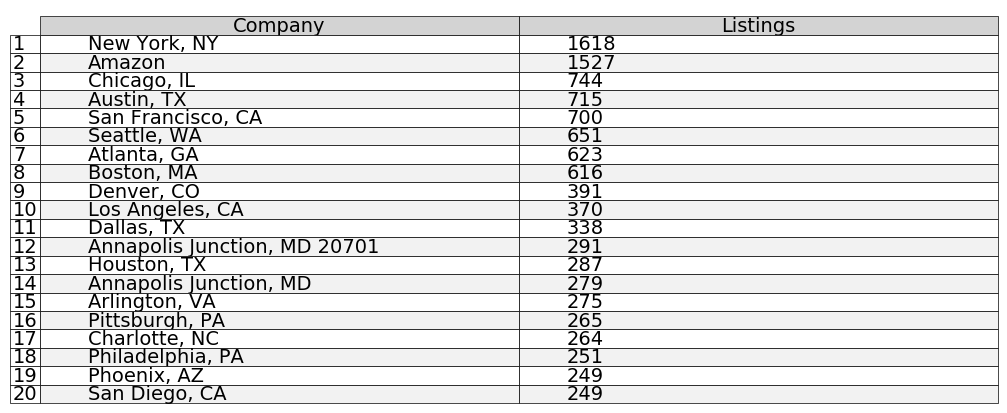

In [348]:
ROWS = tl.shape[0]
COLS = tl.shape[1]
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
ax.table(cellText=[[c,l] for c, l in zip(tl['location'], tl['listings'])],
         colLabels=["Company", "Listings"],
         rowLabels=range(1, ROWS+1),
         cellLoc="left",
         loc="upper left",
         rowColours=["white"]*ROWS,
         colColours=["lightgrey"]*COLS,
         cellColours=[["white" for i in range(COLS)] if j%2==0 else 
                      [".95" for i in range(COLS)] for j in range(ROWS)])
ax.set_facecolor((0,0,0,0))
ax.set_axis_off()
fig.tight_layout()
fig.set_facecolor((0,0,0,0))
plt.grid(False)
plt.show()